# Support Vector Regression

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

%matplotlib inline

In [2]:
import sklearn.decomposition
import sklearn.svm
from sklearn.model_selection import train_test_split

### Support Vector Methods

[Support Vector Machines](https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/)
are a powerful, widely-used technique for classifying data.
[Support Vector Regression](https://alex.smola.org/papers/2003/SmoSch03b.pdf)
is an extension of the more popular support vector machine classifier
to regression problems.

The key tools used by support vector methods are *support vectors* and *kernels*.

#### Kernels

The *kernel function* takes two data points and computes a measure of their similarity.
For example, the dot product of two vectors is a linear kernel function.
Another example of a kernel function is the
*squared exponential* kernel,
also known as the *Gaussian* kernel
or the *radial basis function*.
Mathematically, it looks like this:

$$
k(x,x') = \exp\left(-\frac{(x-x')^2}{2l}\right)
$$

Plotted out, the similarity to a Gaussian is clear:

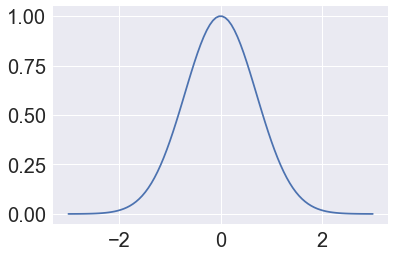

In [6]:
xs = np.linspace(-3,3,100)
plt.plot(xs,np.exp(-1*np.square(xs)));

#### Support Vectors

The *support vectors* are a subset of the training set.

To calculate the prediction of a support vector method for an input,
we take the input and compute the result of the kernel function
applied to the input and each of the support vectors.

Let's call our test input
$\mathbf{x^*}$,
our support vectors $\mathbf{SV_i}$,
and the outputs of the kernel function
$z_i$.

We calculate those outputs using this equation:

$$
    z_i = k(\mathbf{SV_i},\mathbf{x^*})
$$

We then treat this $\mathbf{z}$ as the inputs to a
[linear model](link to LM notebook).
That is, we calculate the actual output of our support vector machine,
$\hat{y}$
by taking a weighted sum of these $z$s and adding a bias term:

$$
\begin{align}
\hat{y} &= \sum_i w_i z_i + b \\
        &= \mathbf{w}^T\mathbf{z} + b
\end{align}
$$

The choice of support vectors and weights is made, as always,
by optimizing an objective function over the training data.
The details of this optimization procedure are
[extremely interesting](http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf)
and use some very cool math,
but they don't interest us here.

#### Support Vector Regression and Multiple Outputs

However, due to the details of how optimization is performed in support vector regression,
there is not a simple, trivial extension
to the case where there are multiple outputs to predict --
where $\hat{y}$ is a vector, as in our data.

The simplest way around this issue
is to train multiple models,
with each one predicting one dimension of our output:
one model for calcium content,
one model for pH,
and so on.
Then, when we want to predict all five outputs for a new data point,
we combine the predictions of all five models into a single output
by just concatenating them.

In [3]:
def trainSVR(SVR_models,X_train,y_train):
    for output_idx, SVR_model in enumerate(SVR_models):
        SVR_model.fit(X_train,y_train[:,output_idx])

def MCWRMSE(SVR_models,X_test,y_test):
    
    error = np.zeros(len(SVR_models))
    
    for output_idx,SVR_model in enumerate(SVR_models):
        y = y_test[:,output_idx]
        y_hat = SVR_model.predict(X_test)
        error[output_idx] = np.sqrt(np.mean(np.square(y-y_hat)))
    
    return np.mean(error)

In [13]:
def makePlot(schedule,train_scores,test_scores):
    
    mean_train_scores = np.mean(train_scores,axis=0)
    mean_test_scores = np.mean(test_scores,axis=0)

    sd_train_scores = np.std(train_scores,axis=0,ddof=1)
    sd_test_scores = np.std(test_scores,axis=0,ddof=1)
    
    plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    
    plt.errorbar(schedule,mean_train_scores,
                 yerr=sd_train_scores,
             linewidth=4,alpha=0.75,
             label='Train')
    
    plt.errorbar(schedule,mean_test_scores,
                 yerr=sd_test_scores,
             linewidth=4,alpha=0.75,
             label='Test')
    
    plt.ylim([0,1]);

    plt.xlabel("Hyperparameter Value");
    plt.ylabel("MCWRMSE")
    plt.legend();
    
def getBest(test_scores,to_keep_schedule):
    
    mean_test_scores = np.mean(test_scores,axis=0)
    
    best_score_index = np.argmax(mean_test_scores)
    best_score = mean_test_scores[best_score_index]
    best_score_num_dimensions = to_keep_schedule[best_score_index]
    print("the best value of the HP is: "+ str(best_score_num_dimensions))

In [4]:
train = pd.read_csv('../data/training.csv')

train.head()

,PIDN,m7497.96,m7496.04,m7494.11,m7492.18,m7490.25,m7488.32,m7486.39,m7484.46,m7482.54,...,REF7,RELI,TMAP,TMFI,Depth,Ca,P,pH,SOC,Sand
0,XNhoFZW5,0.302553,0.301137,0.299748,0.300354,0.302679,0.303799,0.301702,0.298936,0.298126,...,-0.646673,1.687734,0.190708,0.056843,Topsoil,-0.295749,-0.041336,-1.129366,0.353258,1.269748
1,9XNspFTd,0.270192,0.268555,0.266964,0.267938,0.271013,0.272346,0.269870,0.266976,0.266544,...,-0.646673,1.687734,0.190708,0.056843,Subsoil,-0.387442,-0.231552,-1.531538,-0.264023,1.692209
2,WDId41qG,0.317433,0.316265,0.314948,0.315224,0.316942,0.317764,0.316067,0.313874,0.313301,...,-0.814516,1.806660,0.190708,0.056843,Topsoil,-0.248601,-0.224635,-0.259551,0.064152,2.091835
3,JrrJf1mN,0.261116,0.259767,0.258384,0.259001,0.261310,0.262417,0.260534,0.258039,0.257246,...,-0.814516,1.806660,0.190708,0.056843,Subsoil,-0.332195,-0.318014,-0.577548,-0.318719,2.118477
4,ZoIitegA,0.260038,0.258425,0.256544,0.257030,0.259602,0.260786,0.258717,0.256352,0.255902,...,-0.780242,0.430513,0.190708,0.056843,Topsoil,-0.438350,-0.010210,-0.699135,-0.310905,2.164148


In [5]:
data_columns = [column for column in train.columns if column.startswith('m')]
wavenumbers = [float(column.lstrip('m')) for column in data_columns]

output_columns = ["Ca","P","pH","SOC","Sand"]

X = train[data_columns].as_matrix()
y = train[output_columns].as_matrix()

## Best Model

As with most successful machine learning methods,
support vector methods have
hyperparameters that must be tuned with
[cross-validation]().
Because training an ensemble of five support vector regression models
takes much longer than training any of our other models,
we use a special from of cross-validation,
called *greedy cross-validation*,
as described in the section below.

This process still takes a good amount of time
\- on the order of an hour on a laptop.
If you'd just like to train up the best model
so you can inspect it,
simply run the cells below.

In [20]:
C=100; epsilon=1e-4; gamma=1e-2 #selected, in that order, by greedy cross-validation

In [21]:
num_outputs = y.shape[1]

SVR_models = [sklearn.svm.SVR(kernel='rbf',
                            C=C, epsilon=epsilon, gamma=gamma) for _ in range(num_outputs)]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)

In [23]:
trainSVR(SVR_models,X_train,y_train)

In [24]:
MCWRMSE(SVR_models,X_test,y_test)

0.43231048869770949

## Greedy Cross-Validation

Because support vector methods take a long time to train, we chose to run *greedy* cross-validation. That is, we used cross-validation to optimize one hyperparameter, holding the others fixed, then fixed the value of that hyperparameter and moved on to the next one.

There are three major hyperparameters:
- `epsilon` - errors smaller than `epsilon` don't contribute to the cost function. Higher values discourage over-fitting, but may cause under-fitting.
- `C` - determines how intensely to punish errors larger than `epsilon`. Higher values give more complex decision functions, at the cost of potential over-fitting.
- `gamma` - inversely determines the width of the basis function. With smaller values, the data points selected as support vectors will influence predictions further and further away, resulting in smoother predictions that might under-fit.

The below cells check `C` across eight orders of magnitude.
Note that the performance is measured as the
[mean columnwise root mean squared error](),
so lower values indicate better performance.

In [22]:
C_schedule = np.logspace(-5,2,8)
num_splits = 10

train_scores = np.zeros((num_splits,len(C_schedule)))
test_scores = np.zeros_like(train_scores)

for C_idx,C in enumerate(C_schedule):
    SVR_models = [sklearn.svm.SVR(C=C) for _ in range(num_outputs)]
    for split_idx in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        trainSVR(SVR_models,X_train,y_train)
        train_scores[split_idx,C_idx] = MCWRMSE(SVR_models,X_train,y_train)
        test_scores[split_idx,C_idx] = MCWRMSE(SVR_models,X_test,y_test)

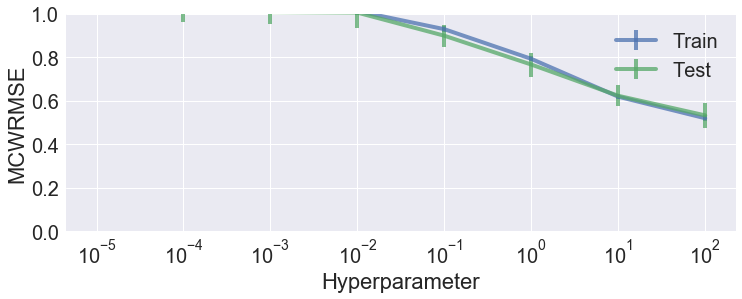

In [26]:
makePlot(C_schedule,train_scores,test_scores)

Interestingly, the performance is still improving,
even with `C` 100 times higher than the suggested default value!

To determine if performance on the test set continues to improve,
we check `C` across five more orders of magnitude.

In [27]:
C_schedule = np.logspace(2,5,5)
num_splits = 10

train_scores = np.zeros((num_splits,len(C_schedule)))
test_scores = np.zeros_like(train_scores)

for C_idx,C in enumerate(C_schedule):
    SVR_models = [sklearn.svm.SVR(C=C) for _ in range(num_outputs)]
    for split_idx in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        trainSVR(SVR_models,X_train,y_train)
        train_scores[split_idx,C_idx] = MCWRMSE(SVR_models,X_train,y_train)
        test_scores[split_idx,C_idx] = MCWRMSE(SVR_models,X_test,y_test)

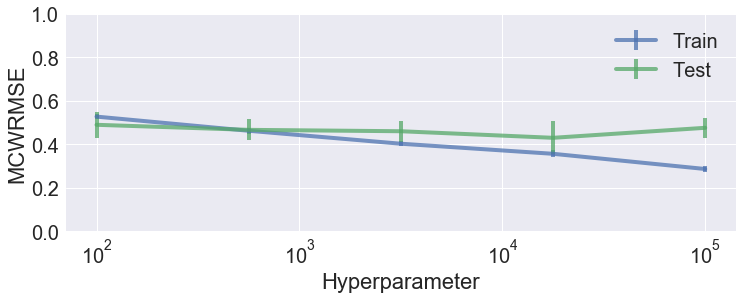

In [28]:
makePlot(C_schedule,train_scores,test_scores)

From the chart above,
it appears that error on the test set appears to bottom out,
even as the training error keeps going down.
This is a classic sign of
[overfitting](),
and one of the primary concerns for modeling
small datasets like ours is overfitting,
so we select a relatively conservative value of `C`: 100.

The next cell tests `epsilon` across four orders of magnitude, with `C` set to the value determined above.
The default value of `epsilon` caused very high training and test error,
so we aimed for smaller values of `epsilon`.

In [11]:
eps_schedule = np.logspace(-5,-2,4)
num_splits = 10

train_scores = np.zeros((num_splits,len(eps_schedule)))
test_scores = np.zeros_like(train_scores)

for eps_idx,eps in enumerate(eps_schedule):
    SVR_models = [sklearn.svm.SVR(epsilon=eps,C=100) for _ in range(num_outputs)]
    for split_idx in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        trainSVR(SVR_models,X_train,y_train)
        train_scores[split_idx,eps_idx] = MCWRMSE(SVR_models,X_train,y_train)
        test_scores[split_idx,eps_idx] = MCWRMSE(SVR_models,X_test,y_test)

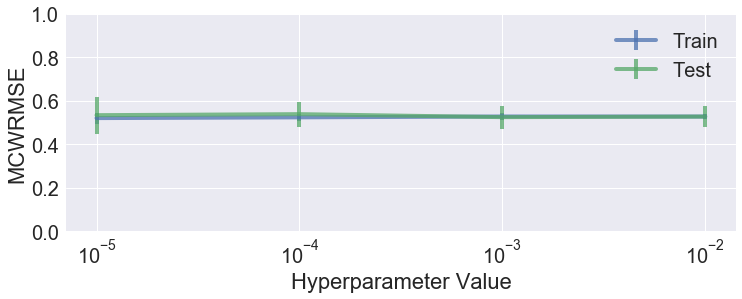

In [14]:
makePlot(eps_schedule,train_scores,test_scores)

Interestingly, varying `epsilon` appeared to have no effect.
We selected a relatively low value of $10^{-4}$.

The last parameter to tune was `gamma`. The default value is 1/`n_features`, or roughly $10^{-3}$.
Again, with over-fitting under control,
our goal was to reduce under-fitting,
so we explored values of `gamma` above the default value.

In [41]:
gamma_schedule = np.logspace(-3,0,10)

num_splits = 10

train_scores = np.zeros((num_splits,len(gamma_schedule)))
test_scores = np.zeros_like(train_scores)

for gamma_idx,gamma in enumerate(gamma_schedule):
    SVR_models = [sklearn.svm.SVR(epsilon=1e-4, C=100, gamma=gamma) for _ in range(num_outputs)]
    for split_idx in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        trainSVR(SVR_models,X_train,y_train)
        train_scores[split_idx,gamma_idx] = MCWRMSE(SVR_models,X_train,y_train)
        test_scores[split_idx,gamma_idx] = MCWRMSE(SVR_models,X_test,y_test)

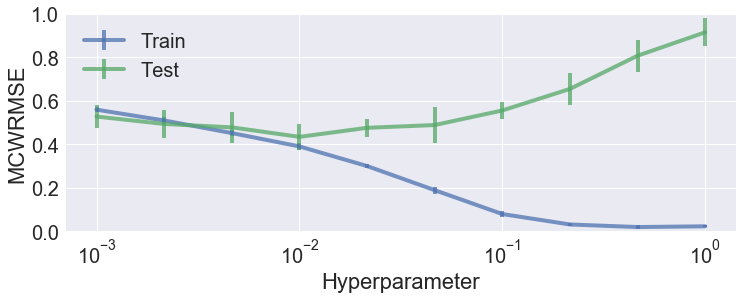

In [42]:
makePlot(gamma_schedule,train_scores,test_scores)

The result was the cleanest cross-validation curve out of the hyperparameters examined:
the transition from fitting to over-fitting is clearly visible at
values above $10^{-2}$,
and the transition towards under-fitting appears to be underway
below that value.